In [1]:
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Data

In [2]:
str_col = ['reference', 'translation']
num_col = ['ref_tox', 'trn_tox', 'similarity', 'lenght_diff']

data = pd.read_csv("data/interim/preprocessed_filtered_1.tsv", sep='\t', index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577777 entries, 0 to 577776
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reference    577777 non-null  object 
 1   translation  577777 non-null  object 
 2   ref_tox      577777 non-null  float64
 3   trn_tox      577777 non-null  float64
 4   similarity   577777 non-null  float64
 5   length_diff  577777 non-null  float64
dtypes: float64(4), object(2)
memory usage: 30.9+ MB


# Prepare Dataloader

In [4]:
from src.data.make_dataset import prepareData, get_dataloader, tensorFromSentence

# Architecture of seq2seq model

In [5]:
from src.models.seq2seq import Seq2Seq, Encoder, Decoder

# Train model

In [6]:
from src.models.train_model import train

In [7]:
epochs = 10
embed_size = 256
hidden_size = 256
batch_size = 128
lr = 1e-3
MAX_LENGTH = 16
model_path = "seq2seq.pt"

teacher_force = 1
teacher_decay = 0.9
teacher_epoch = 2

vocab_tox, vocab_detox, pairs = prepareData(data, MAX_LENGTH)
train_dataloader, val_dataloader = get_dataloader(batch_size, vocab_tox, vocab_detox, pairs, MAX_LENGTH, device=device)

Counted words:
tox-vocab 43165
detox-vocab 37970


In [8]:
encoder = Encoder(vocab_tox.n_words, embed_size, hidden_size, vocab_tox, device=device, max_length=MAX_LENGTH)
decoder = Decoder(embed_size, hidden_size, vocab_detox.n_words, vocab_detox, device=device, max_length=MAX_LENGTH)
seq2seq_model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(seq2seq_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_detox.word2index['<pad>'])

print(sum(p.numel() for p in seq2seq_model.parameters())/1e6, 'Million parameters')

loss_train, loss_val = train(
    seq2seq_model, 
    train_dataloader, 
    val_dataloader, 
    optimizer=optimizer, 
    criterion=criterion, 
    epochs=epochs, 
    lr=lr, 
    model_path=model_path,
    teacher_force=teacher_force,
    teacher_decay=teacher_decay,
    teacher_epoch=teacher_epoch,
)

32.107858 Million parameters


Epoch 10: val: 100%|██████████| 283/283 [00:05<00:00, 55.60it/s, loss=3.94]


# Plot loss

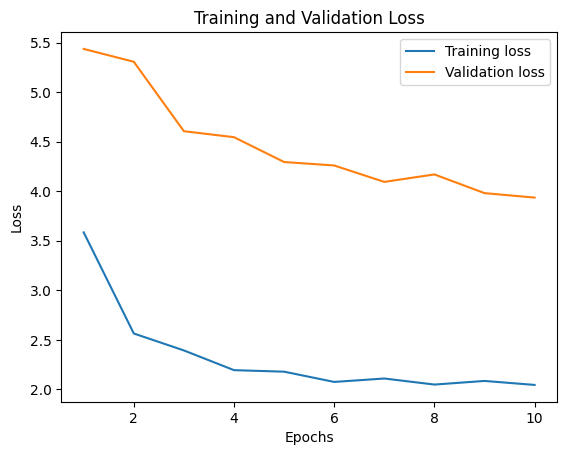

In [9]:
from src.visualization.visualize import plot_loss

plot_loss(loss_train, loss_val, epochs)

# Check in random sample from dataset

In [10]:
def evaluate(model, sentence, vocab_tox, vocab_detox):
    with torch.no_grad():
        model.eval()
        input_tensor = tensorFromSentence(vocab_tox, sentence, device=device)

        outputs = model(input_tensor)

        _, topi = outputs.topk(1)
        ids = topi.squeeze()

        words = []
        for idx in ids:
            if idx.item() == vocab_detox.word2index['<eos>']:
                break
            words.append(vocab_detox.index2word[idx.item()])
    return words

In [11]:
import random
import string

def evaluateRandomly(model, vocab_tox, vocab_detox, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('origin:     ', pair[0])
        print('translated: ', pair[1])
        output_words = evaluate(model, pair[0], vocab_tox, vocab_detox)
        output_sentence = "".join([" "+i if not i.startswith("'") and not i.startswith("n'") and i not in string.punctuation else i for i in output_words]).strip()
        print('predicted:  ', output_sentence)
        print('')

In [21]:
load_seq2seq_model = torch.load(model_path)

load_seq2seq_model.eval()
evaluateRandomly(load_seq2seq_model, vocab_tox, vocab_detox)

origin:      it is as if connie never gave you a free number .
translated:  like you never took a free suck from connie .
predicted:   it is like if you never had a free number.

origin:      you are going to have to finish me .
translated:  you are going to have to finish me off .
predicted:   you are going to finish me off.

origin:      now i am going to buy it on this rock !
translated:  now i am going to buy it on this damn rock !
predicted:   now i am going to buy this rock!

origin:      it is not the music . it is driving me crazy .
translated:  i am going crazy out of this stupid music .
predicted:   it is not the music and i will not crazy.

origin:      why do they keep watching shari ?
translated:  why the hell are they still following ' shari ?
predicted:   why do they keep watching the damn shari shari?

origin:      yeah , i am down to four .
translated:  i have got four bullets .
predicted:   yeah, i am four fucking four. four four.

origin:      hookers love sharing in